In [80]:
import numpy as np
import qnm
import bilby
import matplotlib.pyplot as plt

In [81]:
def shift_model(time, ts, tau, tau_q, fo, f_q, phi, phi_q, A, Aq, t0, **kwargs):
    
    """ 
    
    quantum shift (not fractional)
    
    
    """
    
    plus = np.zeros(len(time))
    cross = np.zeros(len(time))
    
    tidxg = time >= t0
    tidxq = time >= ts
    
    GR_part = A*np.exp(-(time[tidxg]-t0)/tau)*np.exp(1j*((time[tidxg]-t0)*2*np.pi*fo) + phi)
    
    
    plus[tidxg] += GR_part.real 
    
    plus[tidxq] += Q_part.real
    
    return {'plus': plus, 'cross': cross}

In [82]:
def frac_shift_1(time, frac_dw, frac_dtau, dphi, A, w, ts, phi, tau, **kwargs):
    
    """ 
    
    fractional shift: 1 Q mode 
    
    frac_dw, frac_dtau are defined as dw/w (or dtau/tau)
    ts is Q mode start time, phi is phase, w is angular freq., tau is damping time (assumed negative)
        
    outputs plus and cross polarizations as dictionary
    
    get Q values from create_bru_dict function
    
    """
    
    wave = np.zeros(len(time), np.complex128)
    
    tidq = time >= ts
    
    amplitude = A 
    omegar_term = w * (1+frac_dw)
    time_term_q = (time[tidq] - ts)
    phi_term = phi + dphi
    tau_term = tau * (1+frac_dtau)
    
    wave[tidq] = amplitude * np.exp(1j*(omegar_term*time_term_q)) * np.exp(1j*(phi_term)) * np.exp(time_term_q/(tau*frac_dtau))
    
    
    return {'plus': wave.real, 'cross': wave.imag}

In [83]:
def frac_shift_2(time, frac_dw, frac_dtau, dphi, A, t0, w, ts, phi, tau, **kwargs):
    
    """ 
    
    fractional shift: superposition of 1 GR mode and 1 Q mode 
    
    get Q values from create_bru_dict function 
    
    get GR values from qnm package
    
    """
    
    wave = np.zeros(len(time), np.complex128)
    
    tidq = time >= ts
    tidg = time >= t0
    
    amplitude = A 
    omegar_term = w * (1+frac_dw)
    time_term_q = (time[tidq] - ts)
    time_term_g = (time[tidg] - t0)
    phi_term = phi + dphi
    tau_term = tau * (1+frac_dtau)
    
    wave[tidq] += amplitude * np.exp(1j*(omegar_term*time_term_q)) * np.exp(1j*(phi_term)) * np.exp(time_term_q/(tau*frac_dtau))
    wave[tidg] += amplitude * np.exp(1j*(w*time_term_g)) * np.exp(1j*(phi)) * np.exp(time_term_g/(tau))
    
    return {'plus': wave.real, 'cross': wave.imag}

In [109]:
def create_bru_values(m_odd, em, M, a, n_ref, A):
    
    """ 
    m_odd is odd integer, g_s is string coupling (GR == 1), em is 2,
    M is total mass, a is dimensionless spin, and amplitude_qnm is 
    the amplitude of the mode of interest 
    
    returns dictionary: amplitude (quantum, g_s version), omega_real, tau, ts, freq
    outputs tau as a negative number
    
    a refractive index of 1 implies no leakage, AND does not work in this limit (n ~ 1/g_s)
        only the subrelativistic (slow) modes can escape (n>>1) based on boundary conditions 
        (the boundary conditions being the fact that this is a BH copycat)
        
        something to consider is that g_s cannot 0 (which it is in GR) in this model, otherwise there will be 
        no leakage or coupling to outside the "event horizon," which allows stuff to escape
        
        From previous work we can constrain g_s^2 to, at max, be 0.6, which is corresponds to n=1.2
        (this n won't work for this approximation anyway, because the modes close to n = 1 will not 
        escape)
        
        Pick g_s that is ~small~, corresponding to large refractive index
        
         
    """
    g_s = np.sqrt(g_2s)
    c = 3e8
    G = 6.67e-11
    Msun = 1.989e30
    n_ref = 5
    
    conversion_w = (c**3)/(G * M * Msun)
    R_con = (2 * G * M * Msun) / (c**2)
    
    r_s = (R_con + np.sqrt((R_con**2) - 4*(a**2)))/2 #units m, kerr+ radius 
    omega_real = (m_odd * np.pi /(2 * r_s * n_ref)) * c   #units 1/m --> 1/s
    omega_im = - (1/r_s) * (1/(n_ref**2)) * c
    
    tau = 1/omega_im
    ts = 1/omega_real 
    
    amplitude = (g_s**4) * A
    
    print("Q freq is {}".format(omega_real/(2*np.pi)))
    print("Q tau is {}".format(tau))
    
    return {'omega_real_Q': omega_real, 'omega_img_Q': omega_im,
            'tau_Q': tau, 'ts_Q': ts, 'amplitude_Q': amplitude, 'freq_Q': (omega_real/(2*np.pi)),
           'rs_Q': r_s}

In [110]:
def create_GR_values(s, l, m, n, a, M):

    """
    grabs GR values to compare to quantum values
    assumes M in units Msun
    converts from 1/m --> 1/s for angular frequency using GR conversion
    
    returns dictionary of GR tau and GR real omega
    outputs tau as a negative number
    
    """
    
    c = 3e8
    G = 6.67e-11
    Msun = 1.989e30
    conversion_w = (c**3)/(G * M * Msun)
    
    grav = qnm.modes_cache(s=s,l=l,m=m,n=n)
    omega_GR, _, _ = grav(a=a)
    
    omega_real_GR = omega_GR.real * conversion_w
    omega_im_GR = omega_GR.imag * conversion_w
    tau_GR = 1/omega_im_GR
    
    print("GR freq is {}".format(omega_real_GR/(2*np.pi)))
    print("GR tau is {}".format(tau_GR))
    
    return {'tau': tau_GR, 'omega_real_GR': omega_real_GR}

In [111]:
s=2
l=2
m=2
n=0
a=0.7
M=50
t0=0

A = 5e-16

GR_values = create_GR_values(2, l , m, n, a, M)
Q_values = create_bru_values(1, 0, M, a, g_2s, A)

#create fractional for each term

w = GR_values['omega_real_GR']
w_q = Q_values['omega_real_Q']
dw = np.abs(w - w_q)
frac_dw = dw/w

phi = 0
dphi = 0

tau = GR_values['tau']
tau_q = Q_values['tau_Q']
dtau = np.abs(tau-tau_q)
frac_dtau = np.abs(dtau/tau)

A_q = Q_values['amplitude_Q']
dA = np.abs(A-A_q)
frac_dA = dA/A

ts = Q_values['ts_Q']

duration = 1.0
sampling_frequency = 4096
outdir = 'outdir'
label = 'shift_220_M50_frac'

GR freq is 345.02823388207537
GR tau is -0.003040841645301787
Q freq is 101.75907521581921
Q tau is -0.012283916666389656


In [112]:
#parameters from above
injection_parameters = dict(frac_dw=frac_dw, frac_dtau=frac_dtau, 
                            dphi=dphi, A=A, w=w, t0=0, phi=0, tau=tau,
                            geocent_time=0, ra=0, dec=0, psi=0, ts=ts) 

In [113]:
#using model with just stringy mode
waveform = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    time_domain_source_model=frac_shift_1,
    start_time=injection_parameters['geocent_time']-ts)

In [114]:
times = waveform.time_array
wave = frac_shift_1(times, **injection_parameters)['plus']

(0, 0.1)

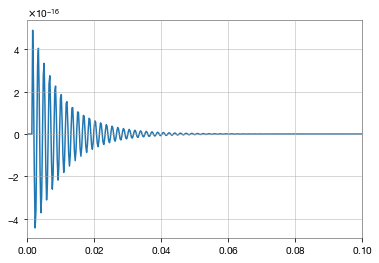


639it [00:21, 87.36it/s, bound:0 nc:6 ncall:1793 eff:35.6% logz-ratio=-inf+/-nan dlogz:inf>0.10]

In [121]:
plt.plot(times, wave)
plt.xlim(0,0.1)

In [116]:
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time']-ts)

ifos.inject_signal(waveform_generator=waveform,
                   parameters=injection_parameters)

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
15:27 bilby INFO    : Injected signal in H1:
15:27 bilby INFO    :   optimal SNR = 5621160.24
15:27 bilby INFO    :   matched filter SNR = 5621159.25-0.10j
15:27 bilby INFO    :   frac_dw = 0.7050702950570744
15:27 bilby INFO    :   frac_dtau = 3.039643657659307
15:27 bilby INFO    :   dphi = 0
15:27 bilby INFO    :   A = 5e-16
15:27 bilby INFO    :   w = 2167.876329689978
15:27 bilby INFO    :   t0 = 0
15:27 bilby INFO    :   phi = 0
15:27 bilby INFO    :   tau = -0.003040841645301787
15:27 bilby INFO    :   geocent_time = 0
15:27 bilby INFO    :   ra = 0
15:27 bilby INFO    :   dec = 0
15:27 bilby INFO    :   psi = 0
15:27 bilby INFO    :   ts = 0.0015640368463878643
15:27 bilby INFO    : Injected signal in L1:
15:27 bilby INFO  

[{'plus': array([ 4.29442212e-20+0.00000000e+00j,
          4.29404997e-20-6.13228394e-22j,
          4.29293349e-20-1.22639859e-21j, ...,
         -6.57480929e-20-2.51044883e-21j,
         -6.57839381e-20-1.25545133e-21j,
         -6.57958879e-20+0.00000000e+00j]),
  'cross': array([1.34368983e-19+0.00000000e+00j,
         1.34343211e-19-2.65139333e-21j,
         1.34265903e-19-5.30180055e-21j, ...,
         1.85979531e-20+7.62970240e-22j,
         1.86096140e-20+3.81563862e-22j,
         1.86135015e-20+0.00000000e+00j])},
 {'plus': array([ 4.29442212e-20+0.00000000e+00j,
          4.29404997e-20-6.13228394e-22j,
          4.29293349e-20-1.22639859e-21j, ...,
         -6.57480929e-20-2.51044883e-21j,
         -6.57839381e-20-1.25545133e-21j,
         -6.57958879e-20+0.00000000e+00j]),
  'cross': array([1.34368983e-19+0.00000000e+00j,
         1.34343211e-19-2.65139333e-21j,
         1.34265903e-19-5.30180055e-21j, ...,
         1.85979531e-20+7.62970240e-22j,
         1.86096140e-20+3

In [117]:
#create priors
prior = injection_parameters.copy()

#prior['tau'] = bilby.core.prior.Uniform(-0.1, -0.0001, r'damping time', unit='$s$')
prior['frac_dtau'] = bilby.core.prior.Uniform(1, 50, r'fraction damping time')

#prior['w'] = bilby.core.prior.Uniform(0, 3000, r'omega', unit='$rad/sec$')
prior['frac_dw'] = bilby.core.prior.Uniform(0.1, 1, r'fraction omega')

prior['ts'] = bilby.core.prior.Uniform(0.005, 0.01, r'start time')

In [118]:
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform)

In [119]:
result = bilby.run_sampler(
    likelihood=likelihood, priors=prior, sampler='dynesty', npoints=500, walks=10, nact=5,
    injection_parameters=injection_parameters, outdir=outdir, label=label, resume=False)

15:27 bilby INFO    : Running for label 'shift_220_M50_frac', output will be saved to 'outdir'
15:27 bilby INFO    : Using LAL version Branch: None;Tag: lal-v6.22.0;Id: 38829b72bfb5f26391b9866d286dd77db7942dd1;;Builder: Duncan Macleod <duncan.macleod@ligo.org>;Repository status: CLEAN: All modifications committed
15:27 bilby INFO    : Search parameters:
15:27 bilby INFO    :   frac_dw = Uniform(minimum=0.1, maximum=1, name='fraction omega', latex_label='fraction omega', unit=None, boundary=None)
15:27 bilby INFO    :   frac_dtau = Uniform(minimum=1, maximum=50, name='fraction damping time', latex_label='fraction damping time', unit=None, boundary=None)
15:27 bilby INFO    :   ts = Uniform(minimum=0.005, maximum=0.01, name='start time', latex_label='start time', unit=None, boundary=None)
15:27 bilby INFO    :   dphi = 0
15:27 bilby INFO    :   A = 5e-16
15:27 bilby INFO    :   w = 2167.876329689978
15:27 bilby INFO    :   t0 = 0
15:27 bilby INFO    :   phi = 0
15:27 bilby INFO    :   ta


0it [00:00, ?it/s]

15:27 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x12667e090>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
15:27 bilby INFO    : Checkpoint every n_check_point = 400000
15:27 bilby INFO    : Using dynesty version 1.0.1
15:27 bilby INFO    : Using the bilby-implemented rwalk sample me


1it [00:01,  1.60s/it, bound:0 nc:1 ncall:501 eff:0.2% logz-ratio=-inf+/-nan dlogz:inf>0.10]
78it [00:01,  1.12s/it, bound:0 nc:1 ncall:581 eff:13.4% logz-ratio=-inf+/-nan dlogz:inf>0.10]
131it [00:01,  1.27it/s, bound:0 nc:1 ncall:646 eff:20.3% logz-ratio=-inf+/-nan dlogz:inf>0.10]
177it [00:01,  1.81it/s, bound:0 nc:1 ncall:704 eff:25.1% logz-ratio=-inf+/-nan dlogz:inf>0.10]
225it [00:02,  2.59it/s, bound:0 nc:3 ncall:768 eff:29.3% logz-ratio=-inf+/-nan dlogz:inf>0.10]
265it [00:02,  3.68it/s, bound:0 nc:1 ncall:830 eff:31.9% logz-ratio=-inf+/-nan dlogz:inf>0.10]
305it [00:02,  5.24it/s, bound:0 nc:2 ncall:904 eff:33.7% logz-ratio=-inf+/-nan dlogz:inf>0.10]
343it [00:02,  7.43it/s, bound:0 nc:1 ncall:975 eff:35.2% logz-ratio=-inf+/-nan dlogz:inf>0.10]
380it [00:02, 10.53it/s, bound:0 nc:2 ncall:1038 eff:36.6% logz-ratio=-inf+/-nan dlogz:inf>0.10]
417it [00:02, 14.83it/s, bound:0 nc:1 ncall:1114 eff:37.4% logz-ratio=-inf+/-nan dlogz:inf>0.10]
454it [00:02, 20.83it/s, bound:0 nc:1 nca

15:27 bilby WARNING : Run terminated with signal 2
15:27 bilby INFO    : Writing checkpoint file outdir/shift_220_M50_frac_resume.pickle



Exception while calling loglikelihood function:
  params: [7.26721988e-01 1.41827618e+01 6.32728675e-03]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/dynesty/dynesty.py", line 939, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/core/sampler/base_sampler.py", line 591, in log_likelihood
    return Sampler.log_likelihood(self, theta)
  File "/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/core/sampler/base_sampler.py", line 389, in log_likelihood
    return self.likelihood.log_likelihood_ratio()
  File "/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/likelihood.py", line 265, in log_likelihood_ratio
    interferometer=interferometer)
  File "/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/likelihood.py", line 190, in calculate_snrs
    d_inner_h = interferometer.inner_product(signal=signal)
  File "/Users/zohaggard/anaconda2/envs/igwn-py

SystemExit: 130

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2886: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
result.plot_corner()